# Aula 7: X do SARIMAX, Auto ARIMA

- Revisão:
    - AR, MA, I e S
    - X e atenções necessárias

- O X da questão:
    - Regressão Linear
    - Combinação simples de um ARIMA com a Regressão
    - Função de Correlação Cruzada e utilização de lags nas inputs
    - Análise de Cenários
    - Variáveis de evento
    - Outliers


In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import seaborn as sns
import warnings
from funcoes import all_ac, plot_forecast, teste_estacionariedade, diagnostico, compara_previsoes, correlacao_cruzada, compara_estatisticas
plt.rcParams["figure.figsize"] = [12, 5]
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../../dados/clicks_original.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.index.freq = 'D'
df = df[:-1] # Tirando o último ponto por ser um outlier, vou discutir isso depois
df

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_67008/1873715214.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df['date'])


,price,location,clicks
date,,,
2008-04-01,43.155647,2,18784
2008-04-02,43.079056,1,24738
2008-04-03,43.842609,2,15209
2008-04-04,43.312376,1,14018
2008-04-05,43.941176,1,11974
...,...,...,...
2008-08-08,43.730836,1,13744
2008-08-09,44.182033,1,6716
2008-08-10,43.608260,1,9523


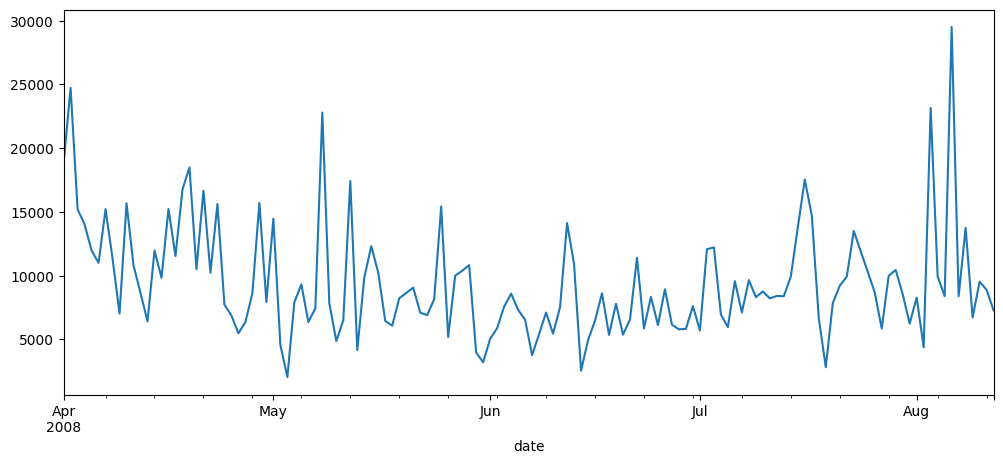

('Não Estacionário', 'Estacionário')

In [3]:
y = df['clicks']
y.plot()
plt.show()
teste_estacionariedade(y)

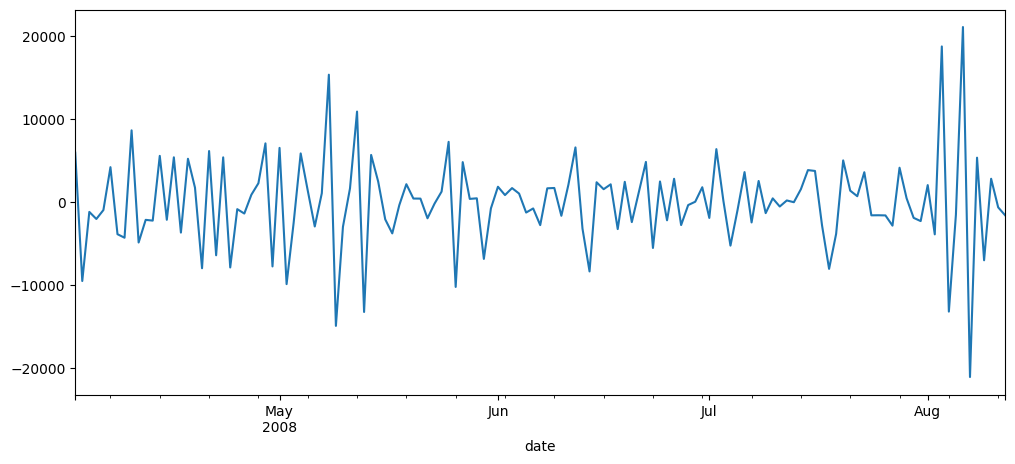

('Estacionário', 'Estacionário')

In [4]:
primeira_ordem = y.diff().dropna()
primeira_ordem.plot()
plt.show()
teste_estacionariedade(primeira_ordem)

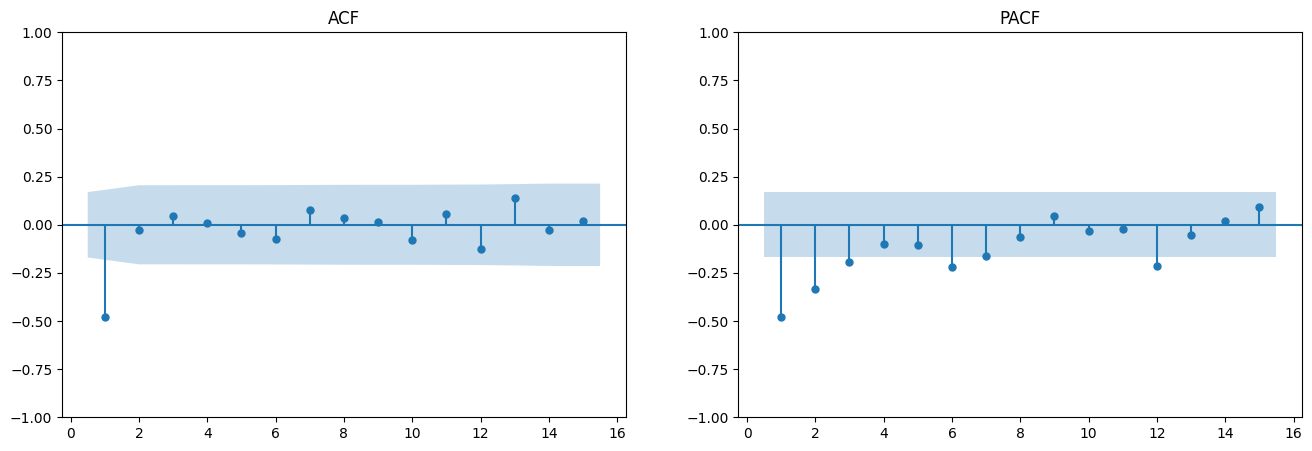

In [5]:
all_ac(primeira_ordem)

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1301.175
Date:                Fri, 02 May 2025   AIC                           2606.350
Time:                        13:01:20   BIC                           2612.131
Sample:                    04-01-2008   HQIC                          2608.699
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9070      0.041    -22.370      0.000      -0.986      -0.828
sigma2      2.017e+07   9.42e-11   2.14e+17      0.000    2.02e+07    2.02e+07
Ljung-Box (L1) (Q):                   0.07   Jarque-

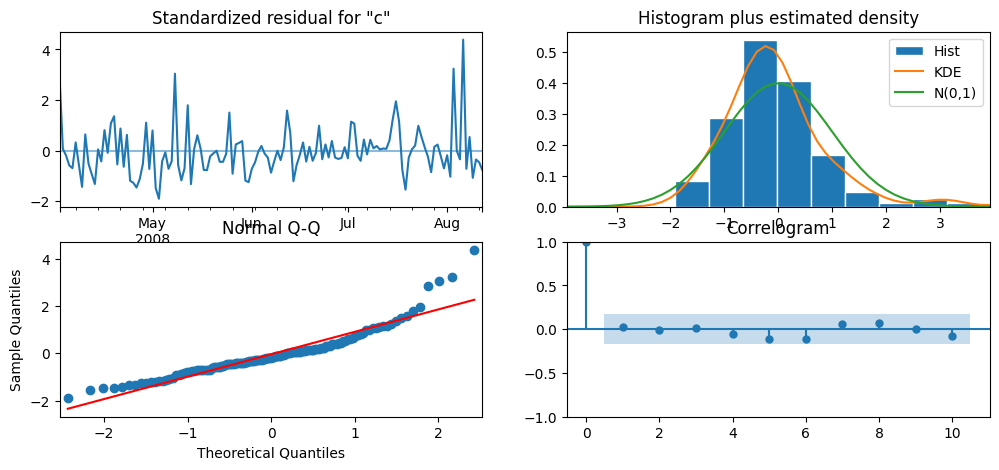

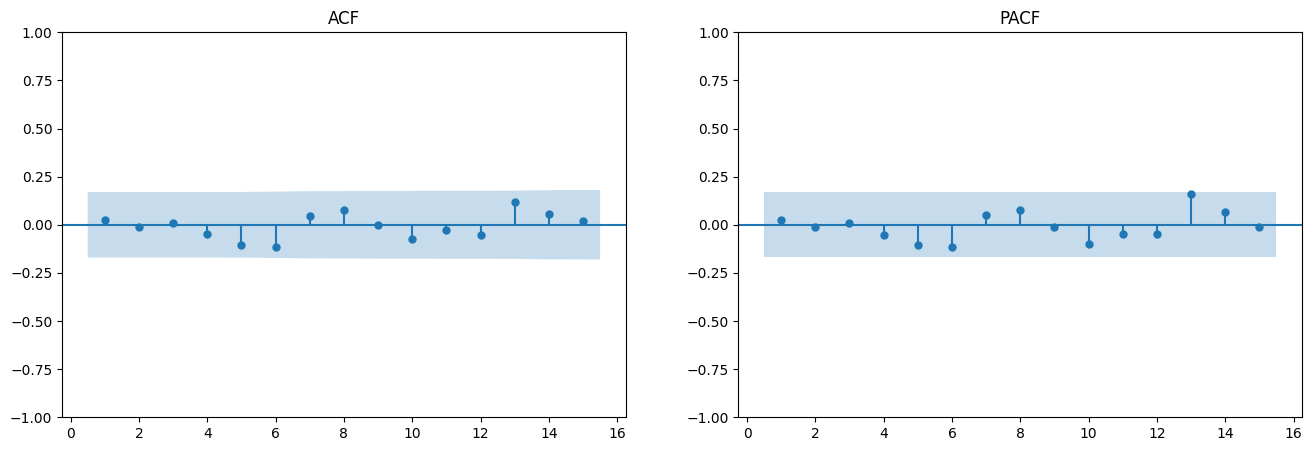

In [6]:
model1 = SARIMAX(y, order=(0,1,1)).fit(disp=False)
diagnostico(model1)

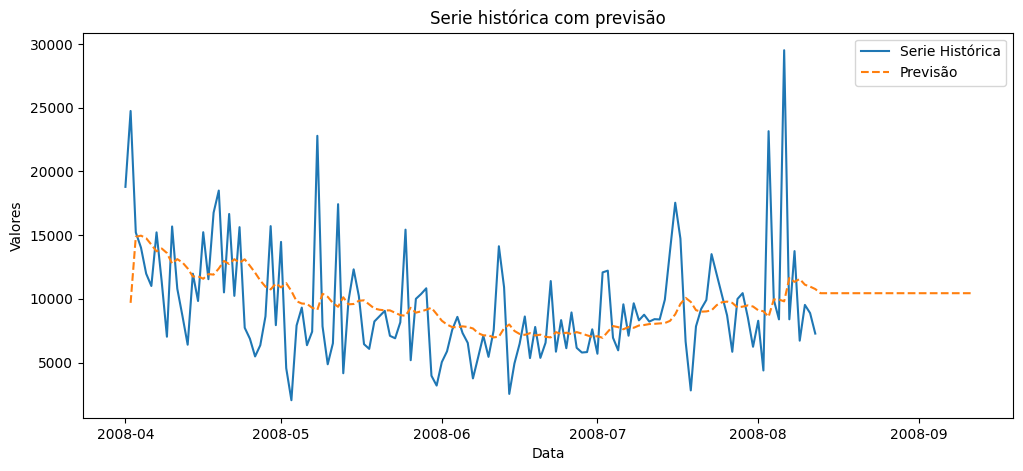

BIC = 2612 - Training RMSE = 4601


In [7]:
forecast = model1.forecast(30)
previsao = model1.fittedvalues[1:]
previsao1 = pd.concat([previsao, forecast])
rmse = np.sqrt(np.mean(model1.resid**2))
bic = model1.bic
plot_forecast(y,previsao1)
print(f'BIC = {round(bic)} - Training RMSE = {round(rmse)}')

Ok, BIC = 2612, RMSE = 4601 não sei se é bom, mas vamos explorar como melhorar o modelo. Talvez com uma Regressão:

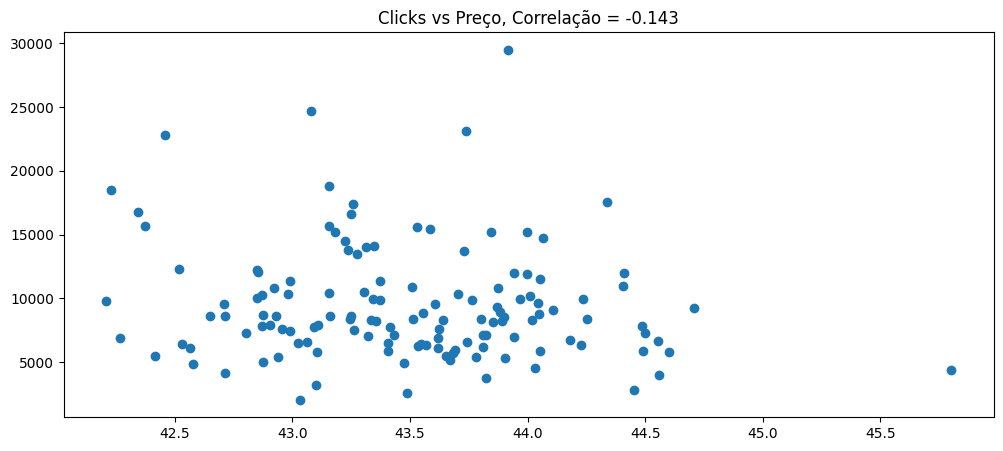

In [8]:
x = df['price']
correl = round(y.corr(x),3)
plt.scatter(x, y)
plt.title(f'Clicks vs Preço, Correlação = {correl}')
plt.show()

In [9]:
import statsmodels.api as sm
model2 = sm.OLS(y, sm.add_constant(x)).fit()
print(model2.summary())

                            OLS Regression Results                            
Dep. Variable:                 clicks   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.013
Method:                 Least Squares   F-statistic:                     2.759
Date:                Fri, 02 May 2025   Prob (F-statistic):             0.0991
Time:                        13:01:21   Log-Likelihood:                -1315.2
No. Observations:                 134   AIC:                             2634.
Df Residuals:                     132   BIC:                             2640.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       5.549e+04   2.77e+04      2.003      0.0

In [10]:
ultima = df.index[-1]
primeiro_for = ultima + pd.Timedelta(days=1)
for_range = pd.date_range(start=primeiro_for, periods=30)
media_preco = df['price'].mean()
preco_futuro = pd.Series([media_preco]*30, index = for_range)

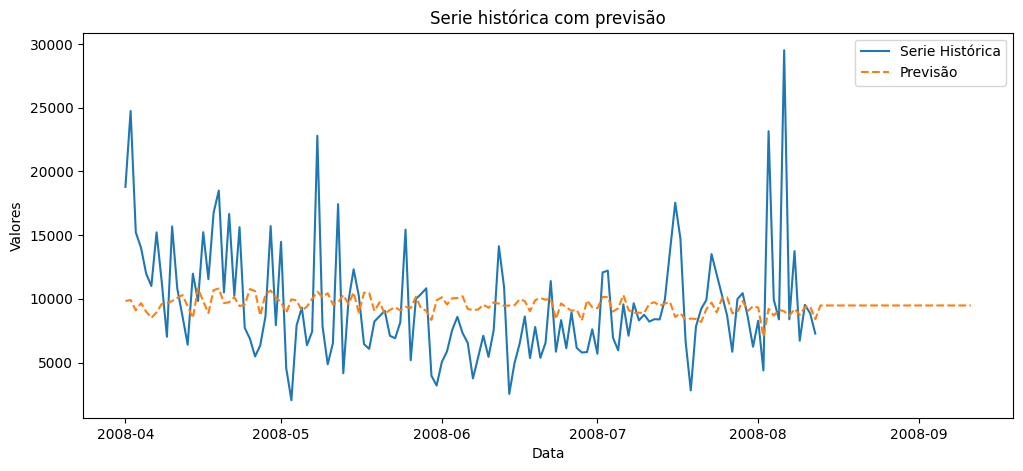

BIC = 2640 - Training RMSE = 4429


In [11]:
preco_futuro_df = pd.DataFrame({'const': 1, 'price': preco_futuro})
forecast = model2.predict(preco_futuro_df)
previsao = model2.fittedvalues
previsao2 = pd.concat([previsao, forecast])
rmse = np.sqrt(np.mean(model2.resid**2))
bic = model2.bic
plot_forecast(y, previsao2)
print(f'BIC = {round(bic)} - Training RMSE = {round(rmse)}')

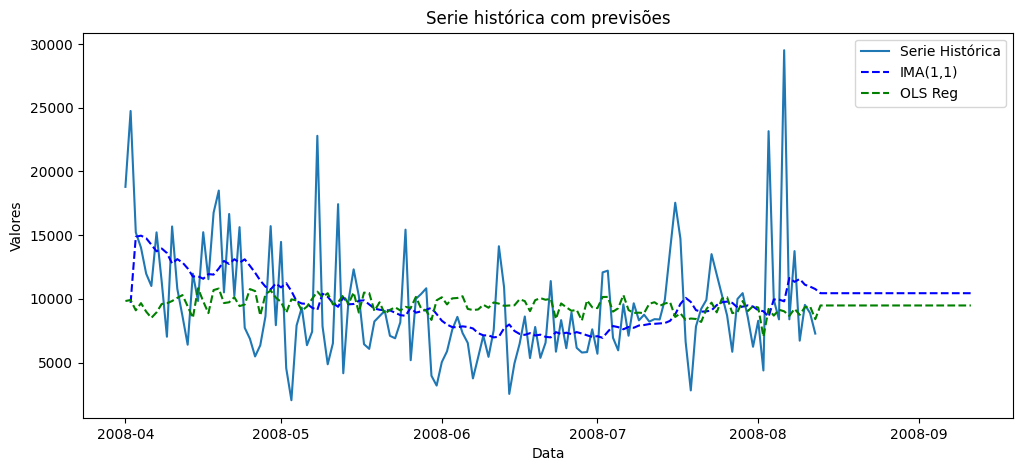

In [12]:
compara_previsoes(y,[previsao1,previsao2], ['IMA(1,1)','OLS Reg'])

Como combinar os dois modelos?
$$ (1 - B)^d (1 - B^s)^D Y_t = c + (1 - \phi_1 B - \dots - \phi_p B^p)(1 - \Phi_1 B^s - \dots - \Phi_P B^{Ps}) Y_t + (1 + \theta_1 B + \dots + \theta_q B^q)(1 + \Theta_1 B^s + \dots + \Theta_Q B^{Qs}) \epsilon_t + \beta_1 x_{1,t} + \beta_2 x_{2,t} + \dots + \beta_k x_{k,t} $$

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1303.587
Date:                Fri, 02 May 2025   AIC                           2615.174
Time:                        13:01:21   BIC                           2626.735
Sample:                    04-01-2008   HQIC                          2619.872
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price        -95.7384    118.044     -0.811      0.417    -327.101     135.624
ar.L1          0.2240      0.084      2.659      0.008       0.059       0.389
ma.L1         -1.0000      0.078    -12.787      0.0

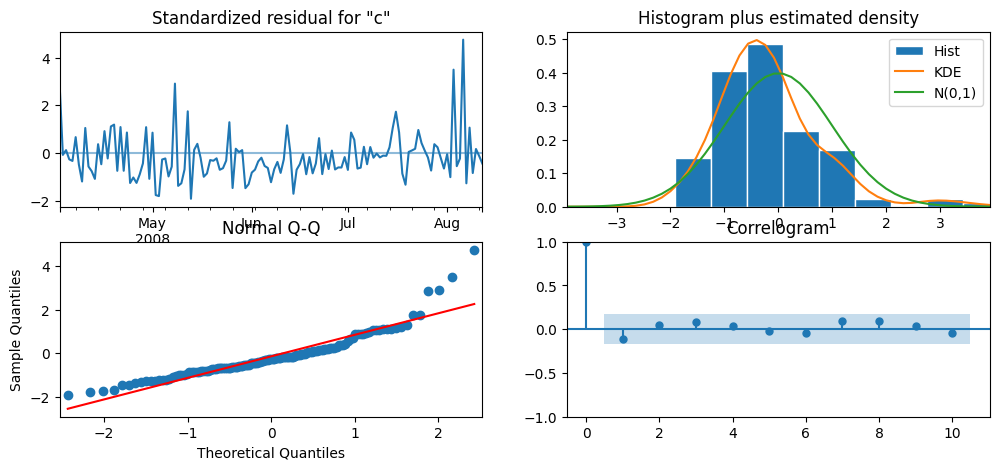

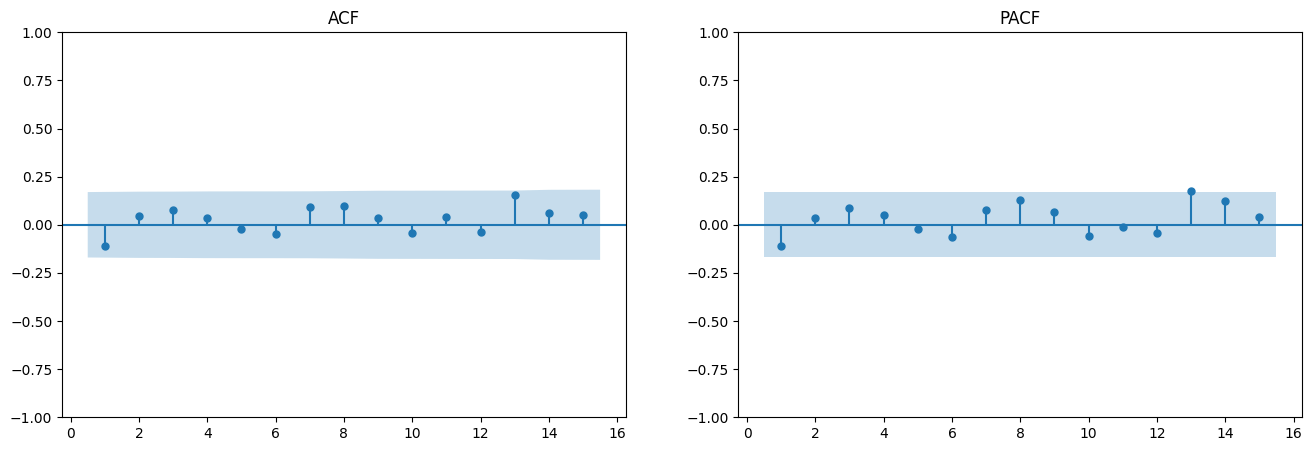

In [13]:
model3 = SARIMAX(y, order=(1,1,1), exog=x).fit(disp=False)
diagnostico(model3)

In [14]:
preco_futuro.head()

2008-08-13    43.484408
2008-08-14    43.484408
2008-08-15    43.484408
2008-08-16    43.484408
2008-08-17    43.484408
Freq: D, dtype: float64

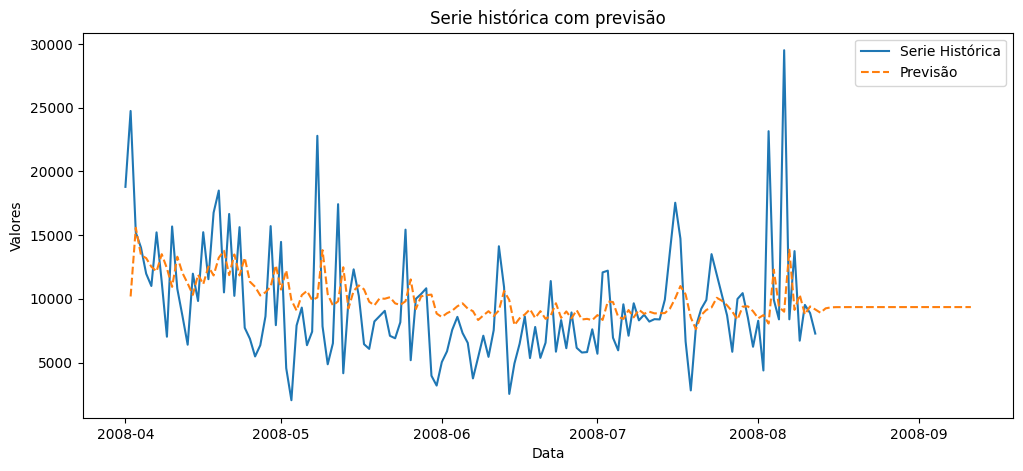

BIC = 2627 - Training RMSE = 4810


In [15]:
forecast = model3.get_forecast(steps=30, exog=preco_futuro).predicted_mean
previsao = model3.fittedvalues[1:]
previsao3 = pd.concat([previsao, forecast])
rmse = np.sqrt(np.mean(model3.resid**2))
bic = model3.bic
plot_forecast(y,previsao3)
print(f'BIC = {round(bic)} - Training RMSE = {round(rmse)}')

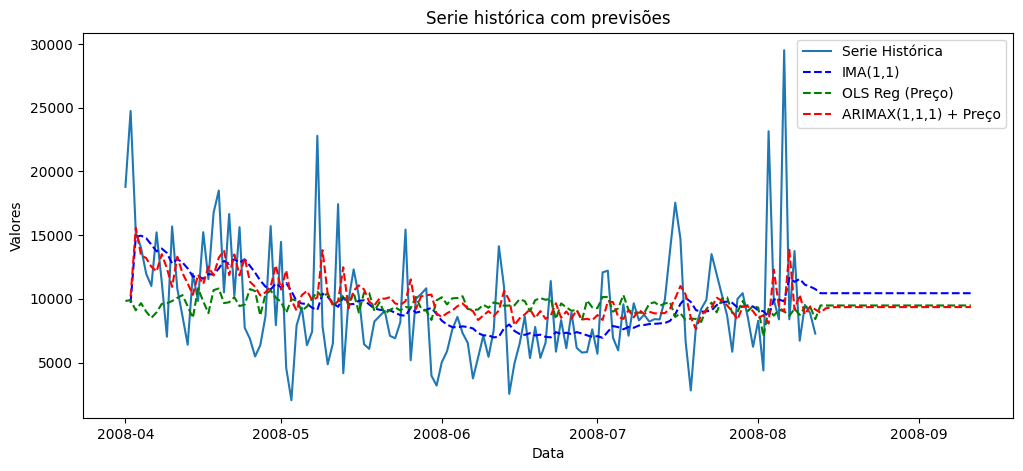

In [16]:
compara_previsoes(y, [previsao1,previsao2,previsao3],  ['IMA(1,1)','OLS Reg (Preço)', 'ARIMAX(1,1,1) + Preço'])

In [17]:
compara_estatisticas( [model1,model2,model3], ['IMA(1,1)','OLS Reg Preço', 'ARIMAX(1,1,1) + Preço'])

BIC = 2612 -- AIC = 2606 --  RMSE = 4601 - IMA(1,1)
BIC = 2640 -- AIC = 2634 --  RMSE = 4429 - OLS Reg Preço
BIC = 2627 -- AIC = 2615 --  RMSE = 4810 - ARIMAX(1,1,1) + Preço


## Análise de Cenários


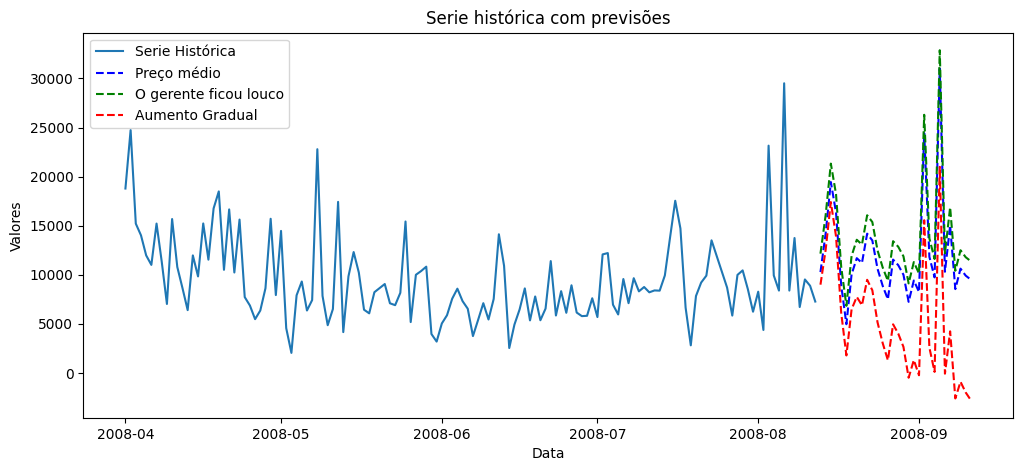

In [18]:

model = SARIMAX(y,order=(1,1,1), seasonal_order=(0,1,0,30), exog=x).fit(disp=False)
passos = 30
preco_medio = df['price'].mean()
preco_medio_f = [preco_medio]*passos
preco_min_f = [42]*passos
aumento_gradual = (df['price'].iloc[-1]) + np.arange(0, 30 * 0.3, 0.3)

cenario1 = model.get_forecast(steps=passos, exog=preco_medio_f).predicted_mean
cenario2 = model.get_forecast(steps=passos, exog=preco_min_f).predicted_mean
cenario3 = model.get_forecast(steps=passos, exog=aumento_gradual).predicted_mean

compara_previsoes(y,[cenario1,cenario2,cenario3], ['Preço médio', 'O gerente ficou louco', 'Aumento Gradual'])

Vamos tentar melhorar o ARIMAX que criamos na primeira demonstração (1,1,1) + Preço

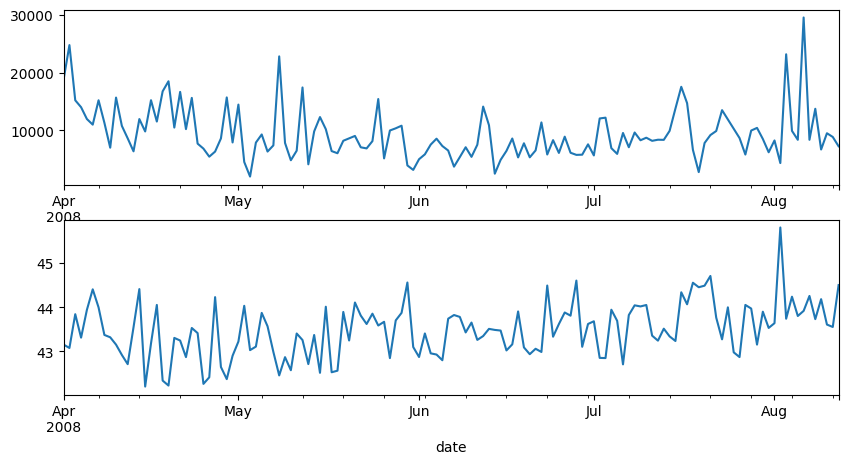

In [19]:
fig, ax = plt.subplots(2, 1, figsize=(10, 5))
y.plot(ax=ax[0])
x.plot(ax=ax[1])
plt.show()

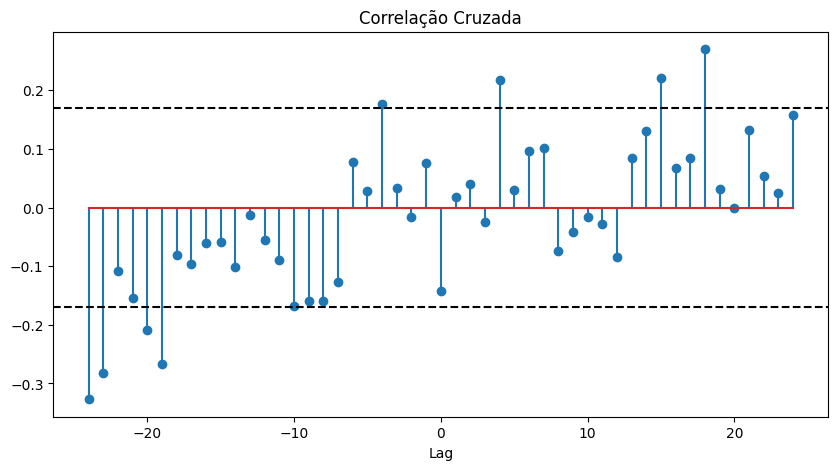

In [20]:
correlacao_cruzada(y,x)

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1303.587
Date:                Fri, 02 May 2025   AIC                           2615.174
Time:                        13:01:22   BIC                           2626.735
Sample:                    04-01-2008   HQIC                          2619.872
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price        -95.7384    118.044     -0.811      0.417    -327.101     135.624
ar.L1          0.2240      0.084      2.659      0.008       0.059       0.389
ma.L1         -1.0000      0.078    -12.787      0.0

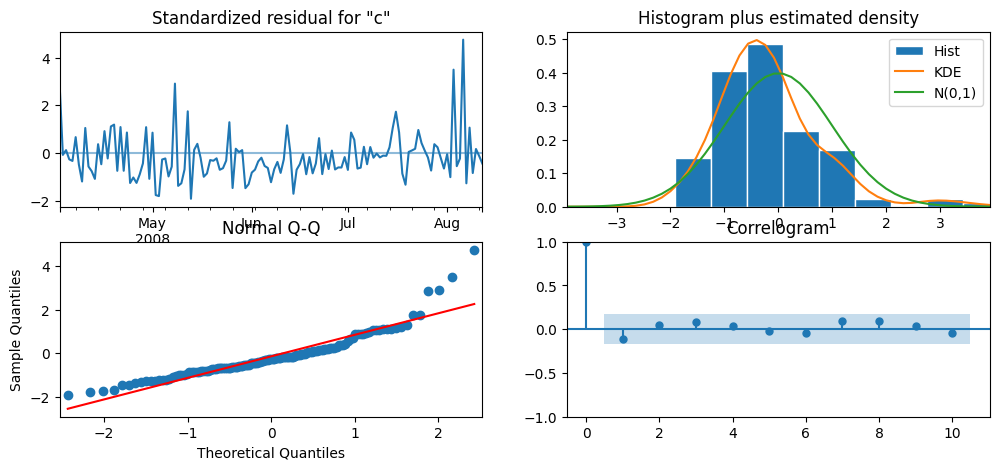

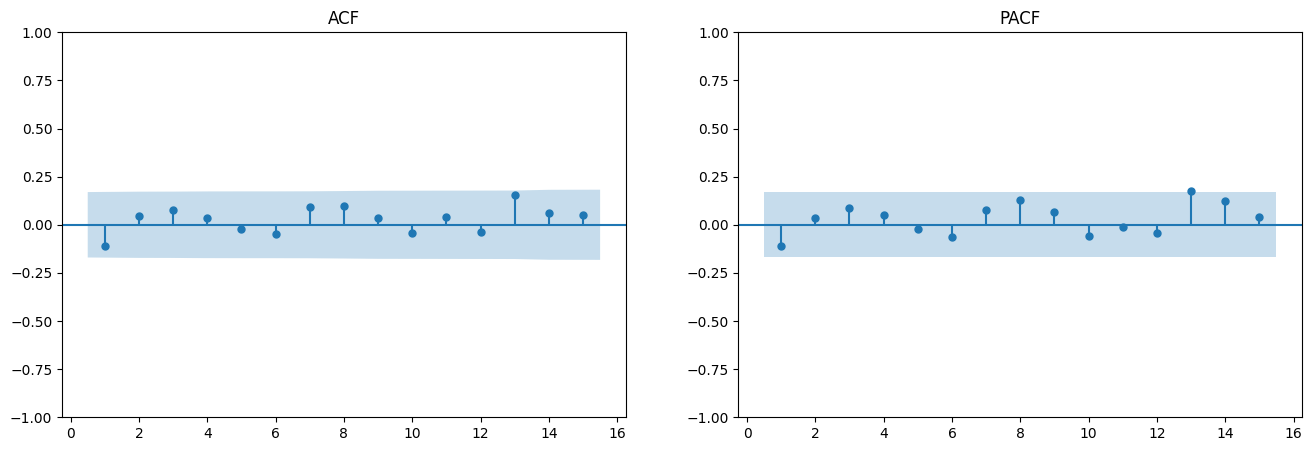

In [21]:
diagnostico(model3)

In [22]:
df['price_4'] = df['price'].shift(4)
df = df.dropna()
df.head(10)

,price,location,clicks,price_4
date,,,,
2008-04-05,43.941176,1,11974,43.155647
2008-04-06,44.403936,1,11007,43.079056
2008-04-07,43.995888,2,15214,43.842609
2008-04-08,43.373773,1,11333,43.312376
2008-04-09,43.320312,1,7026,43.941176
2008-04-10,43.154738,5,15677,44.403936
2008-04-11,42.921659,2,10792,43.995888
2008-04-12,42.713208,1,8642,43.373773
2008-04-13,43.546934,1,6400,43.320312


                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  130
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1252.753
Date:                Fri, 02 May 2025   AIC                           2513.506
Time:                        13:01:22   BIC                           2524.945
Sample:                    04-05-2008   HQIC                          2518.154
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
price      -1506.5108    384.594     -3.917      0.000   -2260.301    -752.721
price_4     1720.1199    339.109      5.072      0.000    1055.479    2384.761
ma.L1         -0.9113      0.037    -24.782      0.0

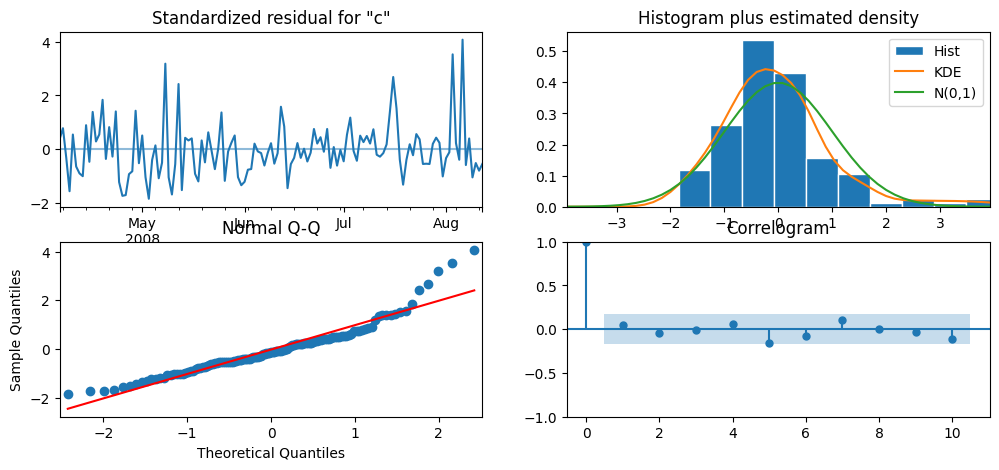

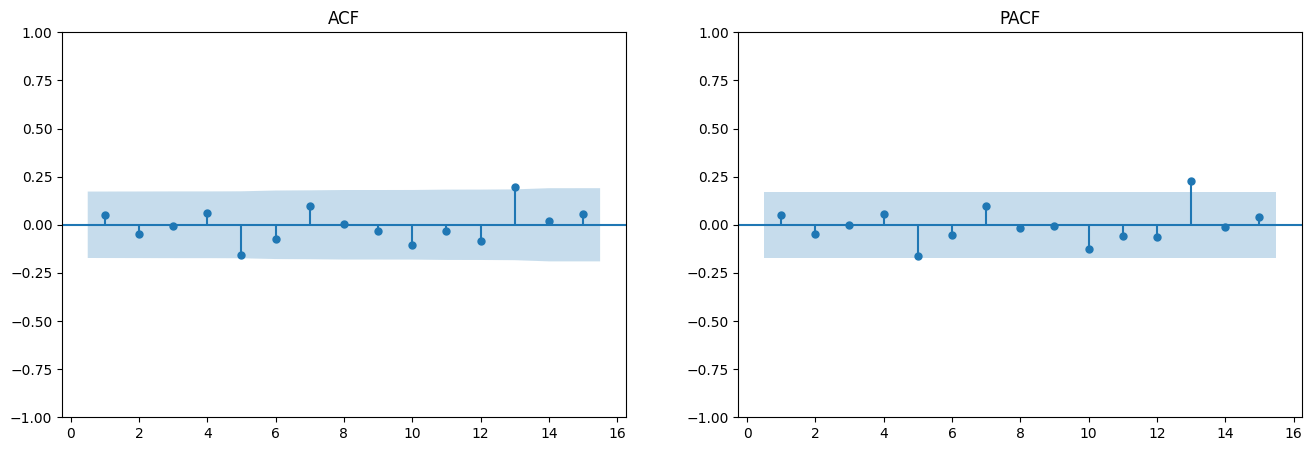

In [23]:
model4 = SARIMAX(df['clicks'], order = (0,1,1), exog=df[['price','price_4']]).fit(disp=False)
diagnostico(model4)

In [24]:
compara_estatisticas( [model1,model2,model3,model4], ['IMA(1,1)','OLS Reg Preço', 'ARIMAX(1,1,1) + Preço', 'ARIMAX(0,1,1) + Preço + Preço(4)'])

BIC = 2612 -- AIC = 2606 --  RMSE = 4601 - IMA(1,1)
BIC = 2640 -- AIC = 2634 --  RMSE = 4429 - OLS Reg Preço
BIC = 2627 -- AIC = 2615 --  RMSE = 4810 - ARIMAX(1,1,1) + Preço
BIC = 2525 -- AIC = 2514 --  RMSE = 3986 - ARIMAX(0,1,1) + Preço + Preço(4)


In [25]:
ultimos_4_precos = df['price'].iloc[-4:]
ultimos_4_precos.index = ultimos_4_precos.index + pd.Timedelta(days=4)
precos_futuros_lag_4 = pd.concat([ultimos_4_precos,preco_futuro.iloc[4:]])
precos = pd.DataFrame({'price': preco_futuro,'price_4': precos_futuros_lag_4 })
precos.head(10)

,price,price_4
2008-08-13,43.484408,44.182033
2008-08-14,43.484408,43.608260
2008-08-15,43.484408,43.553363
2008-08-16,43.484408,44.500469
2008-08-17,43.484408,43.484408
2008-08-18,43.484408,43.484408
2008-08-19,43.484408,43.484408
2008-08-20,43.484408,43.484408
2008-08-21,43.484408,43.484408
2008-08-22,43.484408,43.484408


In [26]:
forecast = model4.get_forecast(steps=30, exog=precos).predicted_mean
previsao = model4.fittedvalues[1:]
previsao4 = pd.concat([previsao, forecast])

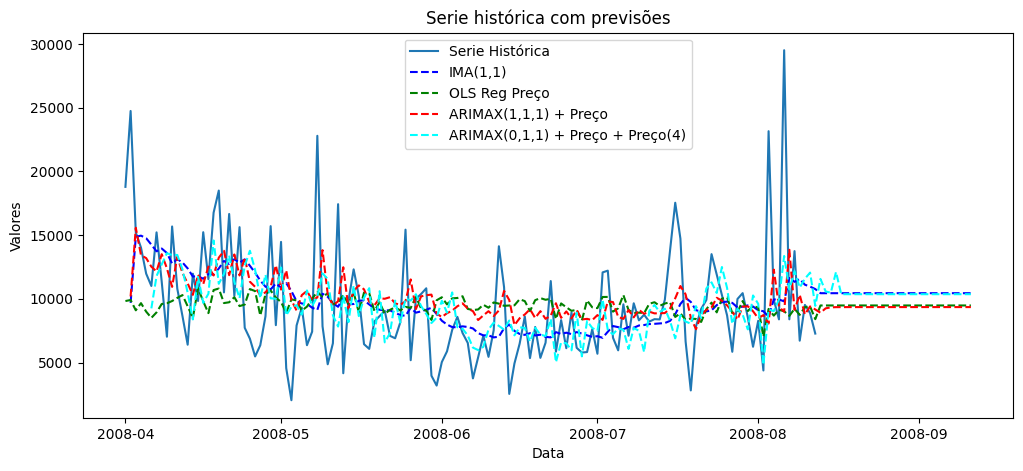

In [27]:
compara_previsoes(y, [previsao1,previsao2,previsao3, previsao4],  ['IMA(1,1)','OLS Reg Preço', 'ARIMAX(1,1,1) + Preço', 'ARIMAX(0,1,1) + Preço + Preço(4)'])

## Variável de evento e outliers

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_67008/3987027772.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df.index = pd.to_datetime(df['date'])


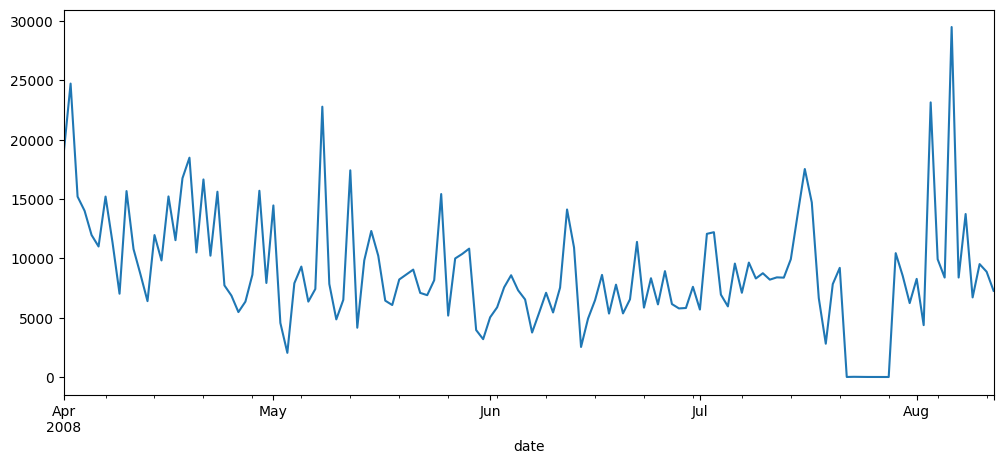

In [28]:
df = pd.read_csv('../../dados/clicks_original_bug.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.index.freq = 'D'
df = df[:-1] # Tirando o último ponto por ser um outlier, vou discutir isso depois
df['clicks'].plot()
plt.show()

In [29]:
import hvplot as hv
import hvplot.pandas
df['clicks'].hvplot()

:Curve   [date]   (clicks)

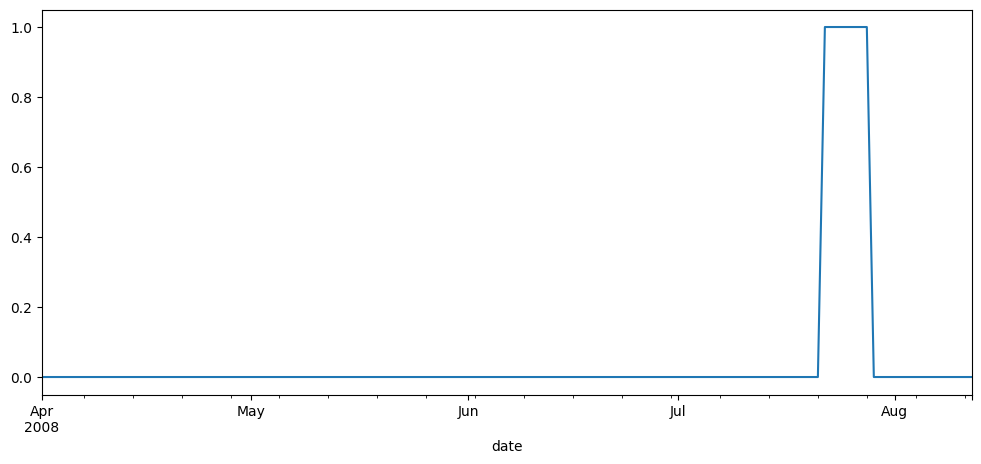

In [30]:
start_date = pd.Timestamp('2008-07-22')
end_date = pd.Timestamp('2008-07-28')
df['bug'] = ((df.index >= start_date) & (df.index <= end_date)).astype(int)
df['bug'].plot()
plt.show()

In [31]:
y = df['clicks']
teste_estacionariedade(y)

('Não Estacionário', 'Estacionário')

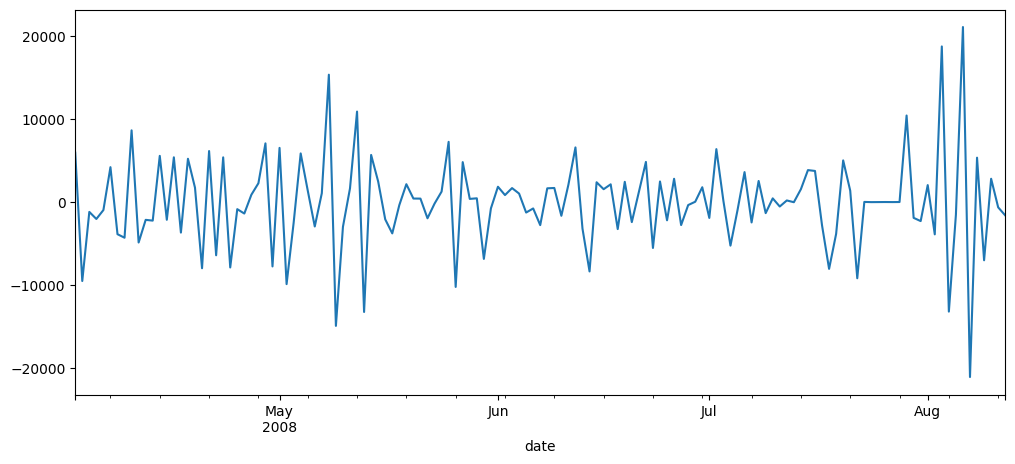

('Estacionário', 'Estacionário')

In [32]:
primeira_ordem = y.diff().dropna()
primeira_ordem.plot()
plt.show()
teste_estacionariedade(primeira_ordem)

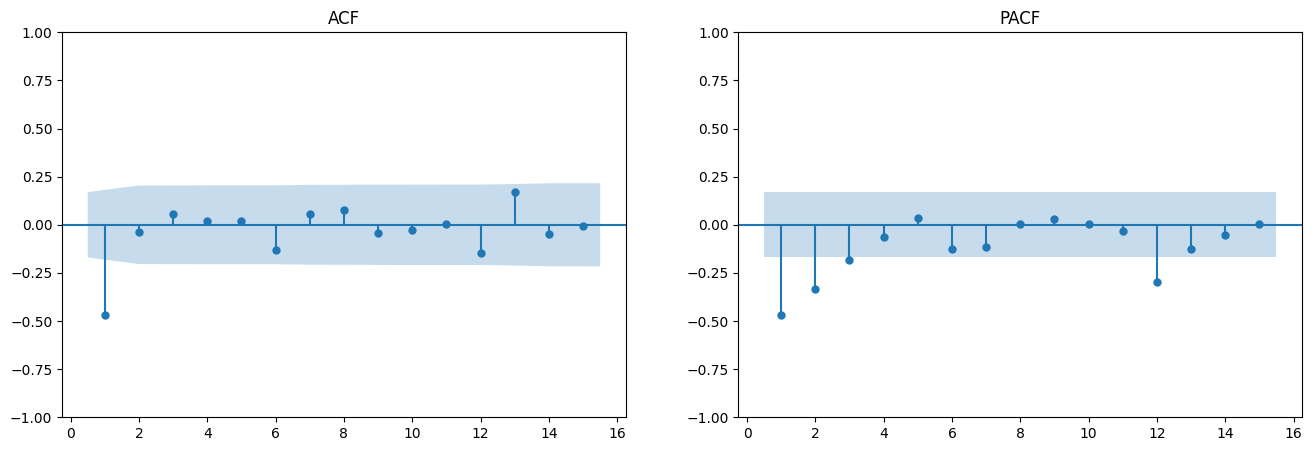

In [33]:
all_ac(primeira_ordem)

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1311.950
Date:                Fri, 02 May 2025   AIC                           2627.900
Time:                        13:01:24   BIC                           2633.681
Sample:                    04-01-2008   HQIC                          2630.249
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7719      0.050    -15.318      0.000      -0.871      -0.673
sigma2      2.131e+07   5.14e-10   4.15e+16      0.000    2.13e+07    2.13e+07
Ljung-Box (L1) (Q):                   0.14   Jarque-

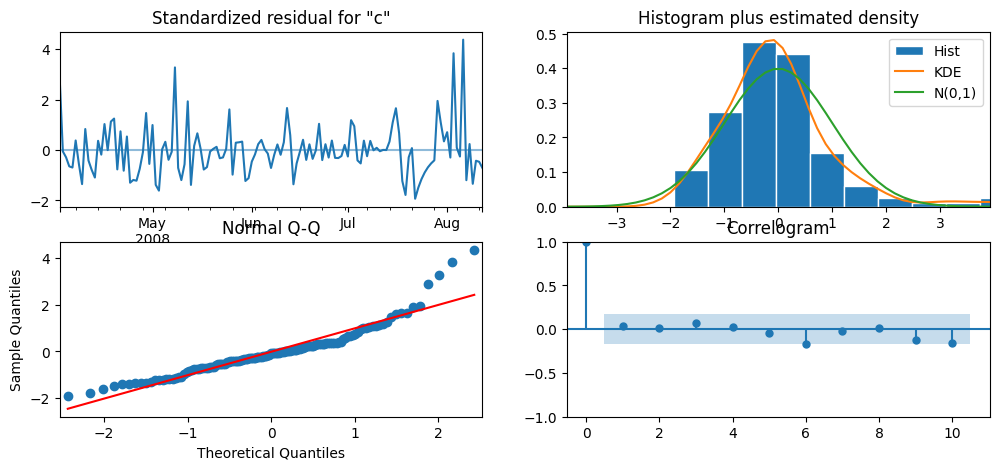

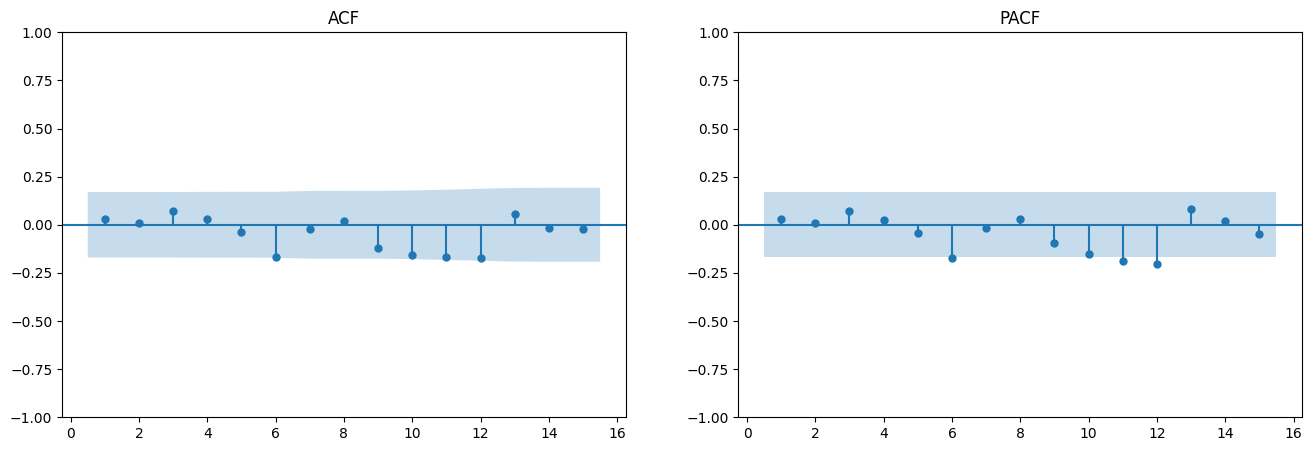

In [34]:
model5 = SARIMAX(df['clicks'], order = (0,1,1)).fit(disp=False)
diagnostico(model5)

In [35]:
df['clicks'].quantile(0.5)

8251.0

                               SARIMAX Results                                
Dep. Variable:                 clicks   No. Observations:                  134
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -1300.004
Date:                Fri, 02 May 2025   AIC                           2606.008
Time:                        13:01:25   BIC                           2614.679
Sample:                    04-01-2008   HQIC                          2609.531
                         - 08-12-2008                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
bug        -9818.0000   2878.369     -3.411      0.001   -1.55e+04   -4176.501
ma.L1         -0.9062      0.040    -22.475      0.000      -0.985      -0.827
sigma2      1.968e+07      4.099    4.8e+06      0.0

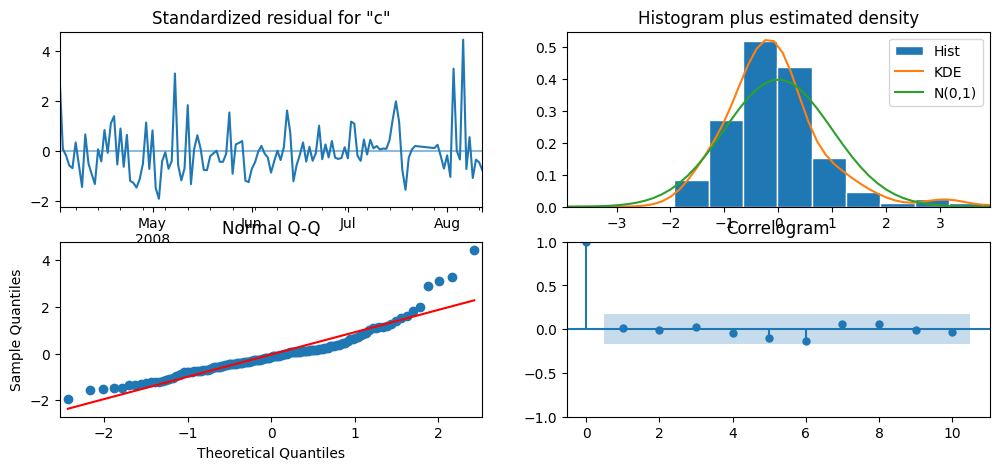

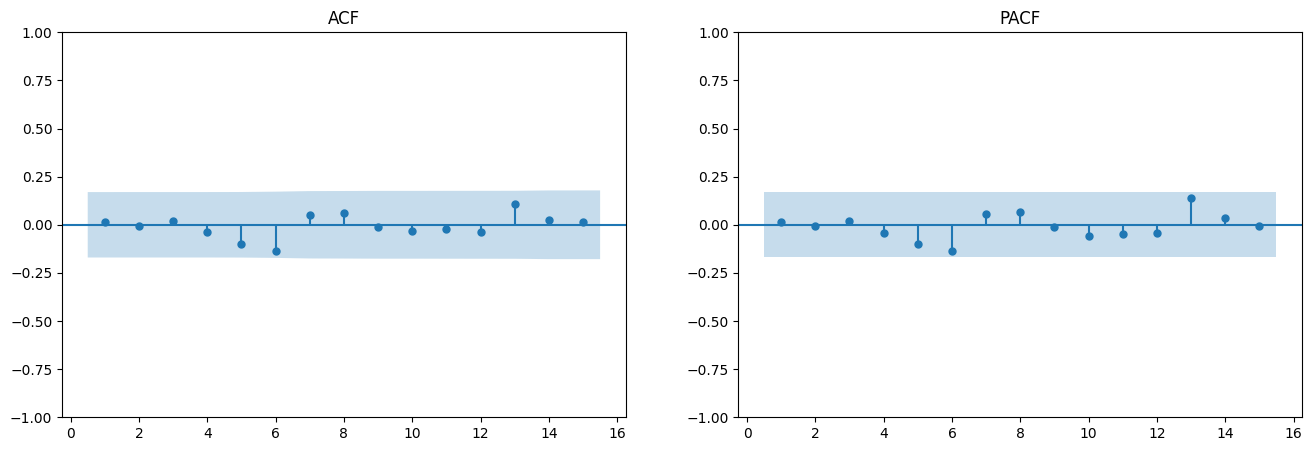

In [36]:
model6 = SARIMAX(df['clicks'], order = (0,1,1), exog=df['bug']).fit(disp=False)
diagnostico(model6)

In [37]:
compara_estatisticas( [model5,model6], ['Sem variável de evento','Com variável de evento'])

BIC = 2634 -- AIC = 2628 --  RMSE = 4936 - Sem variável de evento
BIC = 2615 -- AIC = 2606 --  RMSE = 4568 - Com variável de evento


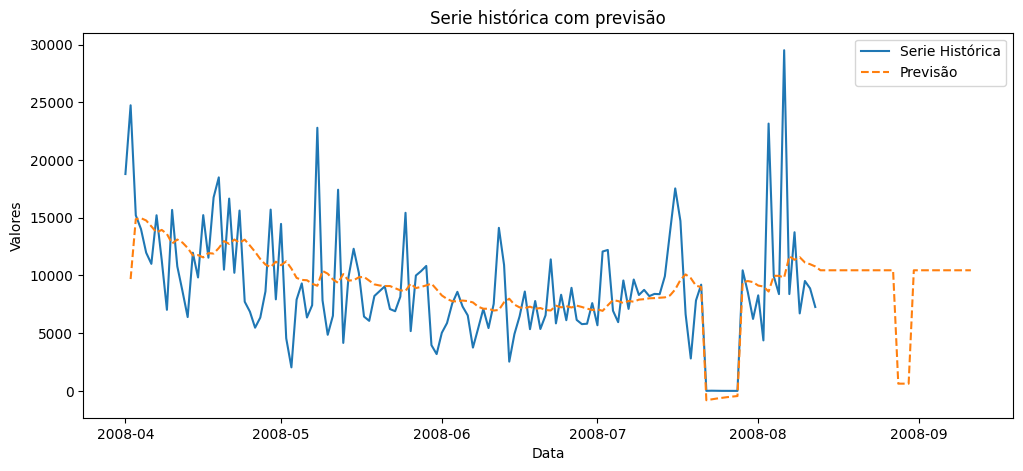

In [38]:
bug_futuro = [0]*15 + [1]*3 + [0]*12
forecast = model6.get_forecast(steps=30, exog=bug_futuro).predicted_mean
previsao = model6.fittedvalues[1:]
previsao6 = pd.concat([previsao, forecast])
plot_forecast(y,previsao6)

## Estudo de caso

In [39]:
from sktime.datasets import load_macroeconomic

In [40]:
econ = load_macroeconomic()
cols = ['realgdp','realdpi','tbilrate', 'unemp', 'infl']
econ_df = econ[cols]
econ_df

,realgdp,realdpi,tbilrate,unemp,infl
Period,,,,,
1959Q1,2710.349,1886.9,2.82,5.8,0.00
1959Q2,2778.801,1919.7,3.08,5.1,2.34
1959Q3,2775.488,1916.4,3.82,5.3,2.74
1959Q4,2785.204,1931.3,4.33,5.6,0.27
1960Q1,2847.699,1955.5,3.50,5.2,2.31
...,...,...,...,...,...
2008Q3,13324.600,9838.3,1.17,6.0,-3.16
2008Q4,13141.920,9920.4,0.12,6.9,-8.79
2009Q1,12925.410,9926.4,0.22,8.1,0.94


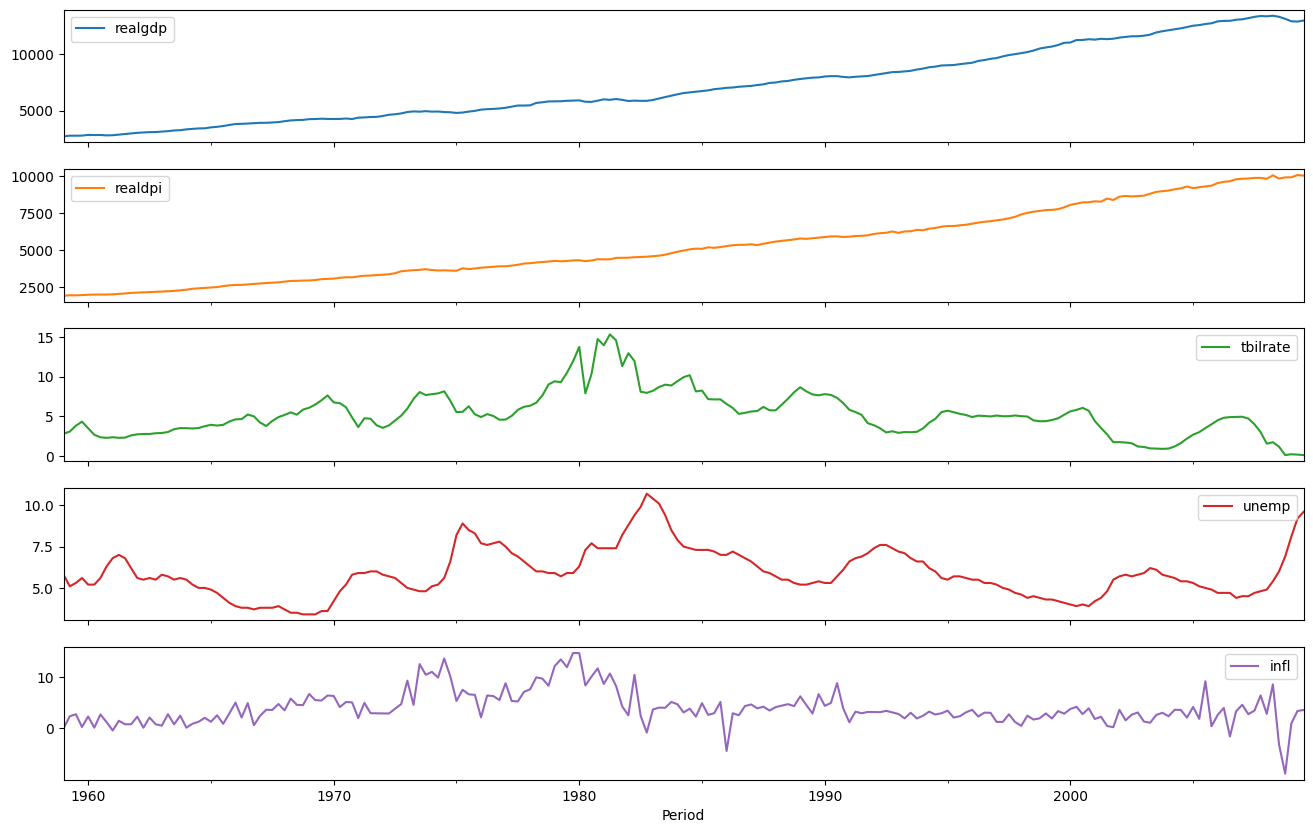

In [41]:
econ_df.plot(subplots=True, figsize=(16, 10))
plt.show()

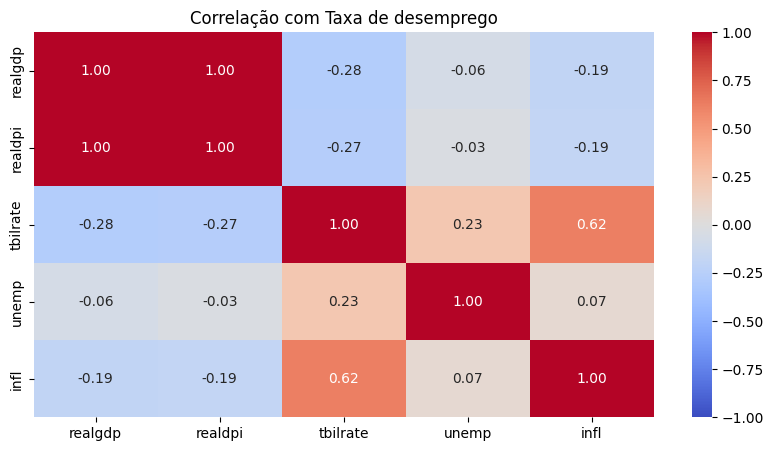

In [42]:
correlation_matrix = econ_df.corr()
unemp_corr = correlation_matrix
plt.figure(figsize=(10, 5))
sns.heatmap(unemp_corr, annot=True, cmap='coolwarm', fmt=".2f", vmin=-1, vmax=1, cbar=True)
plt.title('Correlação com Taxa de desemprego')
plt.show()

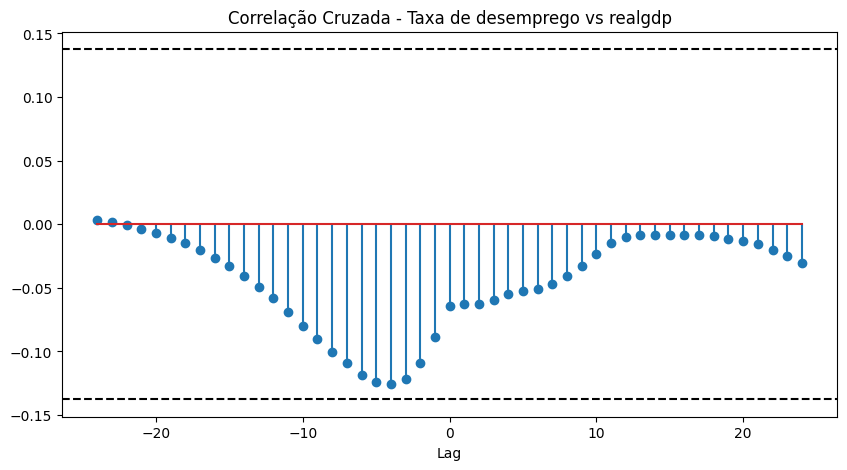

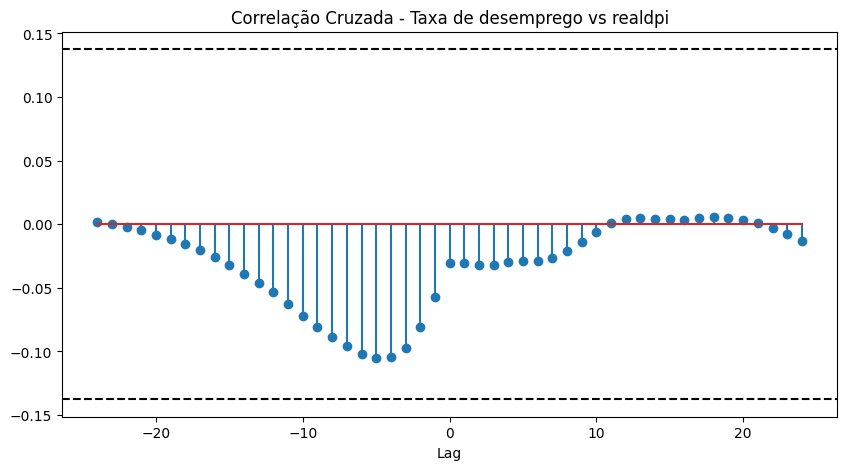

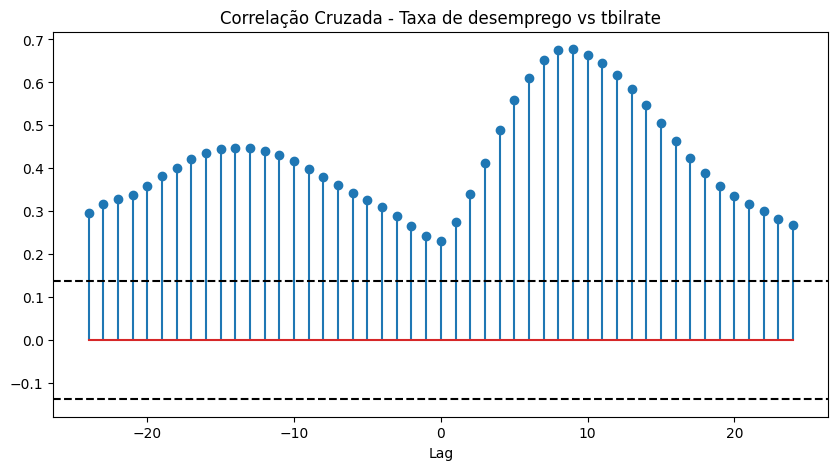

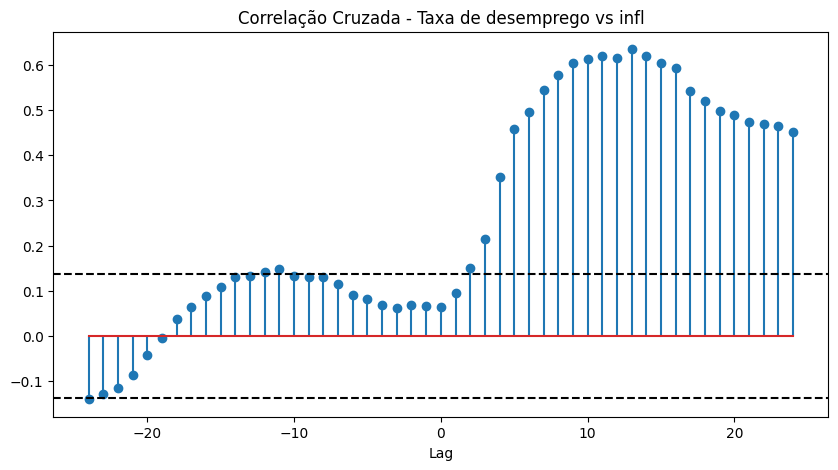

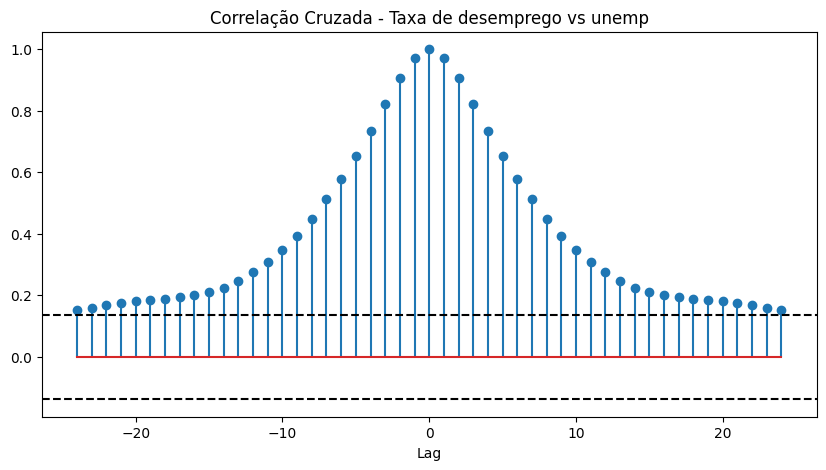

In [43]:
for x in ['realgdp', 'realdpi', 'tbilrate', 'infl', 'unemp']:
    correlacao_cruzada(econ_df['unemp'],econ_df[x], titulo=f'Correlação Cruzada - Taxa de desemprego vs {x}')

In [44]:
y = econ_df['unemp']
teste_estacionariedade(y)

('Estacionário', 'Não Estacionário')

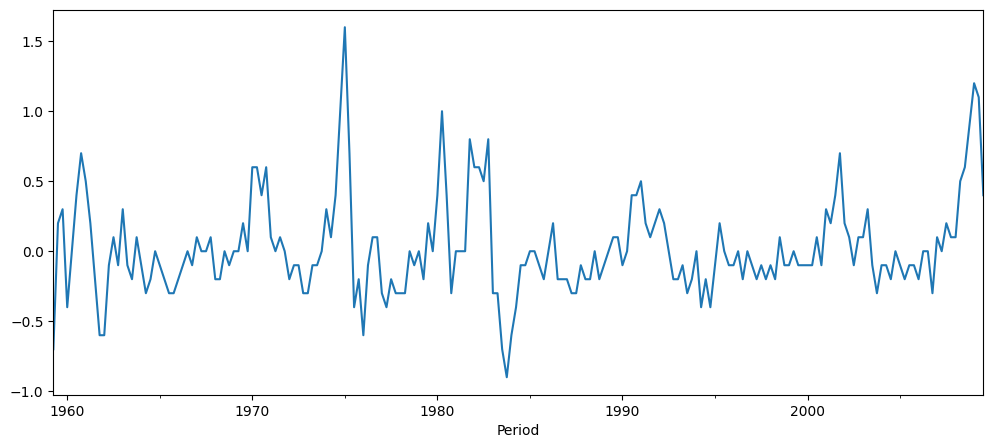

('Estacionário', 'Estacionário')

In [45]:
primeira_ordem = y.diff().dropna()
primeira_ordem.plot()
plt.show()
teste_estacionariedade(primeira_ordem)

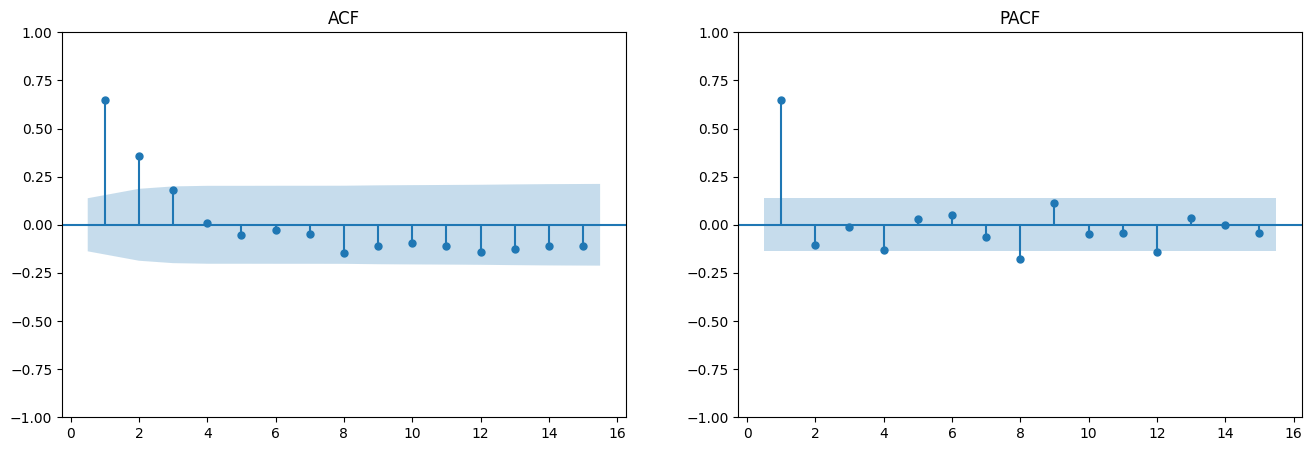

In [46]:
all_ac(primeira_ordem)

In [47]:
econ_df['taxa_juros_9'] = econ_df['tbilrate'].shift(9)

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_67008/1480126705.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_df['taxa_juros_9'] = econ_df['tbilrate'].shift(9)


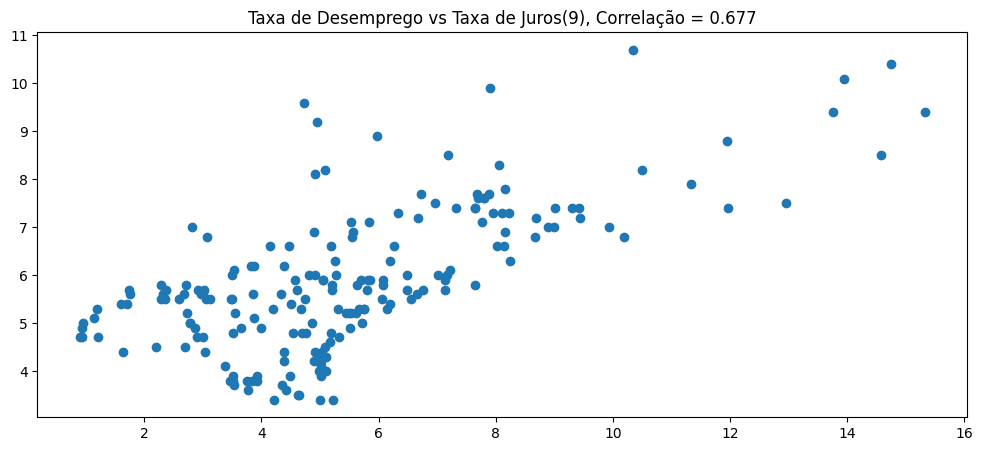

In [48]:
x = econ_df['taxa_juros_9']
correl = round(y.corr(x),3)
plt.scatter(x, y)
plt.title(f'Taxa de Desemprego vs Taxa de Juros(9), Correlação = {correl}')
plt.show()

In [49]:
df_no_miss = econ_df.dropna()

Iteragir aqui:

                                     SARIMAX Results                                     
Dep. Variable:                             unemp   No. Observations:                  203
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -22.307
Date:                           Fri, 02 May 2025   AIC                             52.615
Time:                                   13:01:27   BIC                             65.768
Sample:                               03-31-1959   HQIC                            57.939
                                    - 09-30-2009                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5606      0.063      8.966      0.000       0.438       0.683
ma.L1          0.1855      0.079      2.350

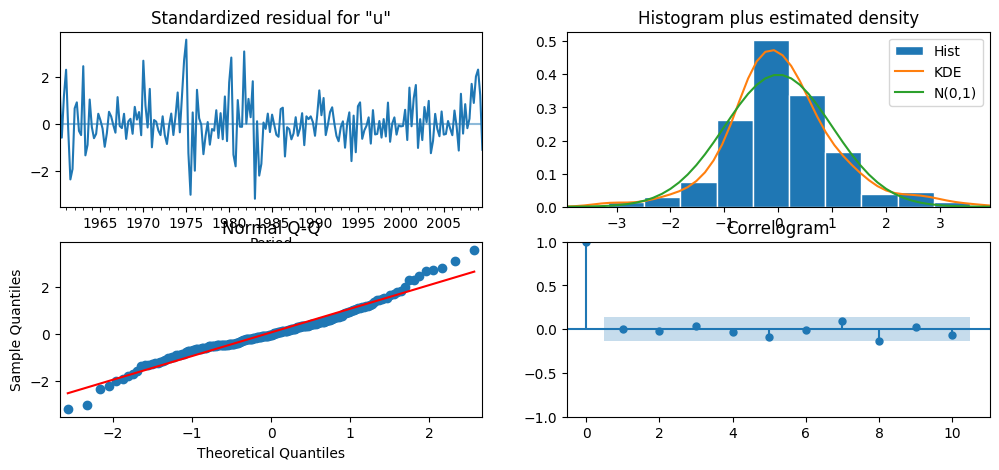

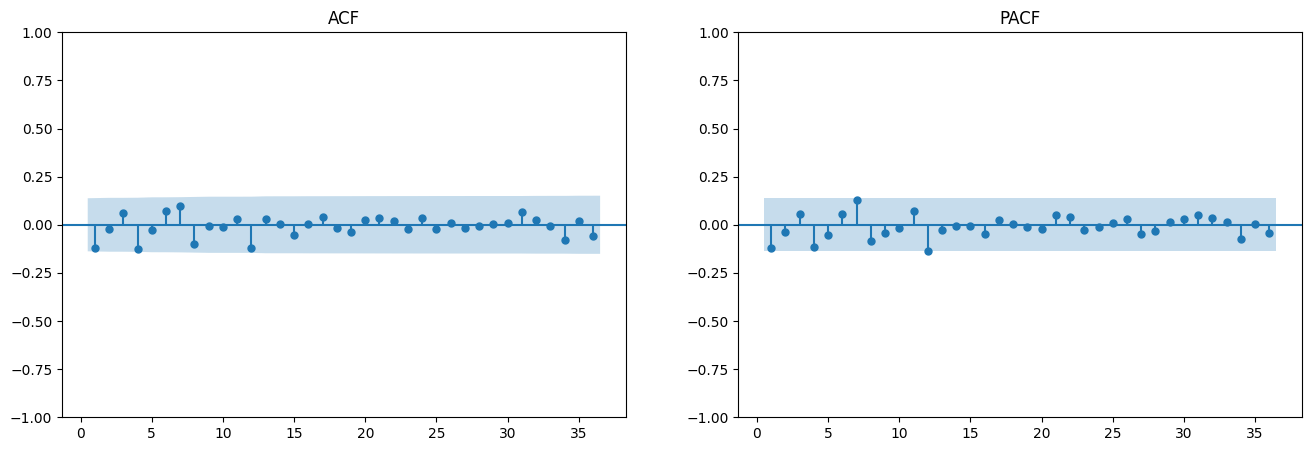

In [50]:
model7 = SARIMAX(econ_df['unemp'], order= (1,1,1), seasonal_order=(0,1,1,4)).fit(disp=False)
diagnostico(model7, lags=36)

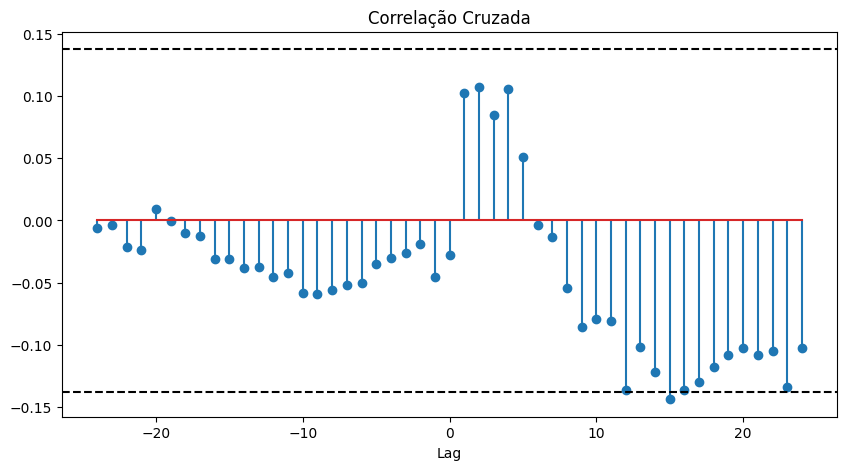

In [51]:
resid = model7.resid
correlacao_cruzada(resid,econ_df['tbilrate'])

In [52]:
econ_df['tj_15'] = econ_df['tbilrate'].shift(15)
df = econ_df.dropna()

/var/folders/f1/tdh3lyp114g78tg5wv2t7g3m0000gn/T/ipykernel_67008/2731429269.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  econ_df['tj_15'] = econ_df['tbilrate'].shift(15)


                                     SARIMAX Results                                     
Dep. Variable:                             unemp   No. Observations:                  188
Model:             SARIMAX(1, 1, 1)x(0, 1, 1, 4)   Log Likelihood                 -12.653
Date:                           Fri, 02 May 2025   AIC                             35.307
Time:                                   13:01:28   BIC                             51.354
Sample:                               12-31-1962   HQIC                            41.811
                                    - 09-30-2009                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
tj_15         -0.0106      0.025     -0.432      0.666      -0.059       0.038
ar.L1          0.6247      0.054     11.469

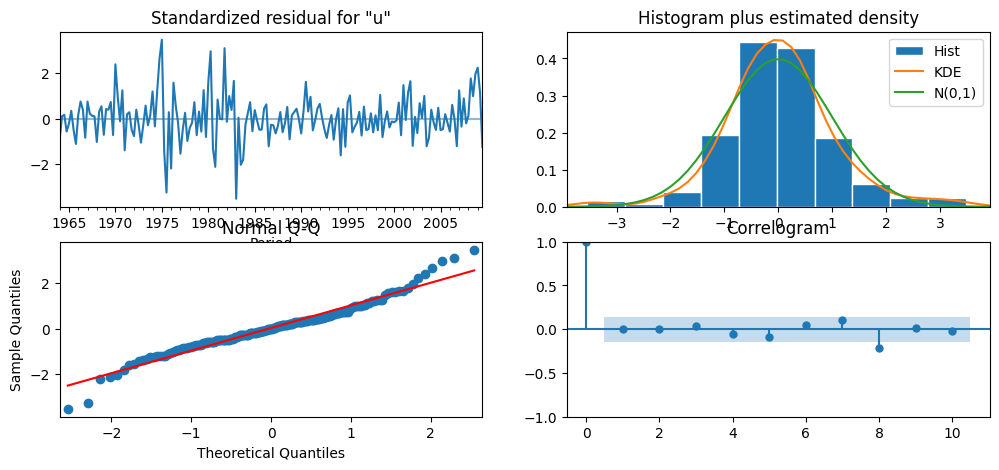

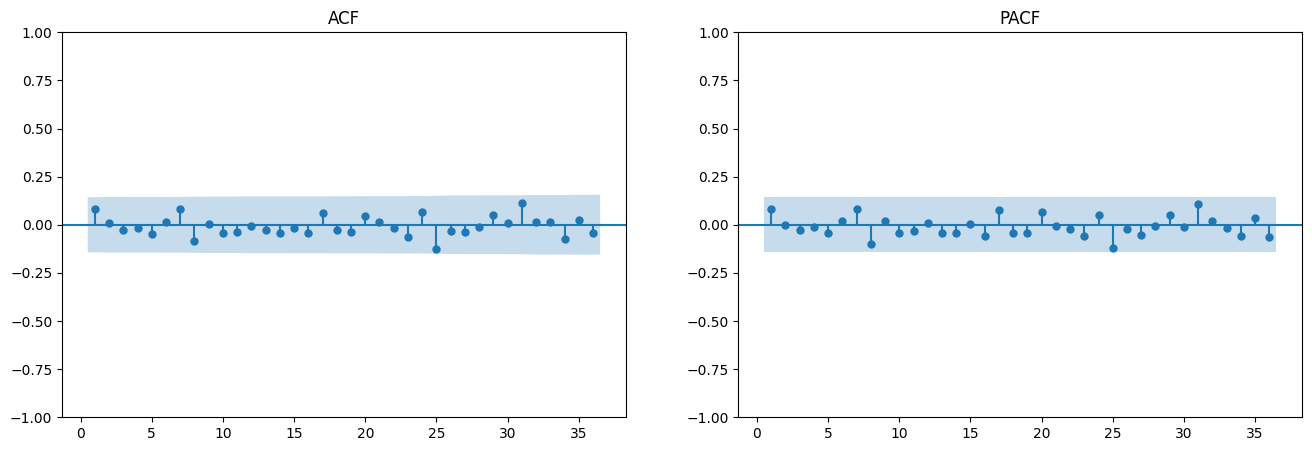

In [53]:
model8 = SARIMAX(df['unemp'], order= (1,1,1), seasonal_order=(0,1,1,4), exog=df['tj_15']).fit(disp=False)
diagnostico(model8, lags=36)

In [54]:
compara_estatisticas( [model7,model8], ['SARIMA','SARIMAX'])

BIC = 66 -- AIC = 53 --  RMSE = 1 - SARIMA
BIC = 51 -- AIC = 35 --  RMSE = 1 - SARIMAX


Se tiver tempo, fazer previsões para os próximos 9 períodos: